In [1]:
from cmath import inf, sin
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def solve_tridiagonal_matrix_system(
    bottom_diagonal: np.ndarray,
    main_diagonal: np.ndarray,
    top_diagonal: np.ndarray,
    scalars: np.ndarray
) -> np.ndarray:
    a, b, c, d = map(np.copy, (
        bottom_diagonal,
        main_diagonal,
        top_diagonal,
        scalars
    ))

    dimension, *_ = b.shape

    for i in range(1, dimension):
        w = a[i - 1] / b[i - 1]
        b[i] = b[i] - w * c[i - 1]
        d[i] = d[i] - w * d[i - 1]

    x = np.copy(b)
    x[-1] = d[-1] / b[-1]

    for i in range(dimension - 2, -1, -1):
        x[i] = (d[i] - c[i] * x[i + 1]) / b[i]

    return x


In [3]:
def solve_second_order_lde(
    A: float, 
    B: float, 
    C: float, 
    *, 
    x: np.ndarray = np.linspace(0, 1, 1000), 
    Y_left: float, 
    Y_right: float, 
    precision: float = 1e-3, 
    max_iterations_count: int = 1000
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Y'' + A * Y' + B * Y + C = 0
    """
    h = (x[-1] - x[0]) / len(x)

    Y = np.array([Y_left + (Y_right - Y_left) * x])

    norm = +inf

    while norm > precision and len(Y) <= max_iterations_count:
        Y_prev = Y[-1]

        a = (1 - 0.5 * h * A) * np.ones((len(x) - 3, ))
        b = (B * h ** 2 - 2) * np.ones((len(x) - 2, ))
        c = (1 + 0.5 * h * A) * np.ones((len(x) - 3, ))

        d = -C * h ** 2 * np.ones((len(x) - 2, ))
        d[0] = d[0] - (1 - 0.5 * h * A) * Y_left
        d[-1] = d[-1] - (1 + 0.5 * h * A) * Y_right

        Y_current = solve_tridiagonal_matrix_system(a, b, c, d)
        Y_current = np.insert(Y_current, 0, Y_left)
        Y_current = np.append(Y_current, Y_right)
        
        norm = np.max(np.abs(Y_current - Y_prev))
        Y = np.append(Y, [Y_current], axis=0)

    return Y


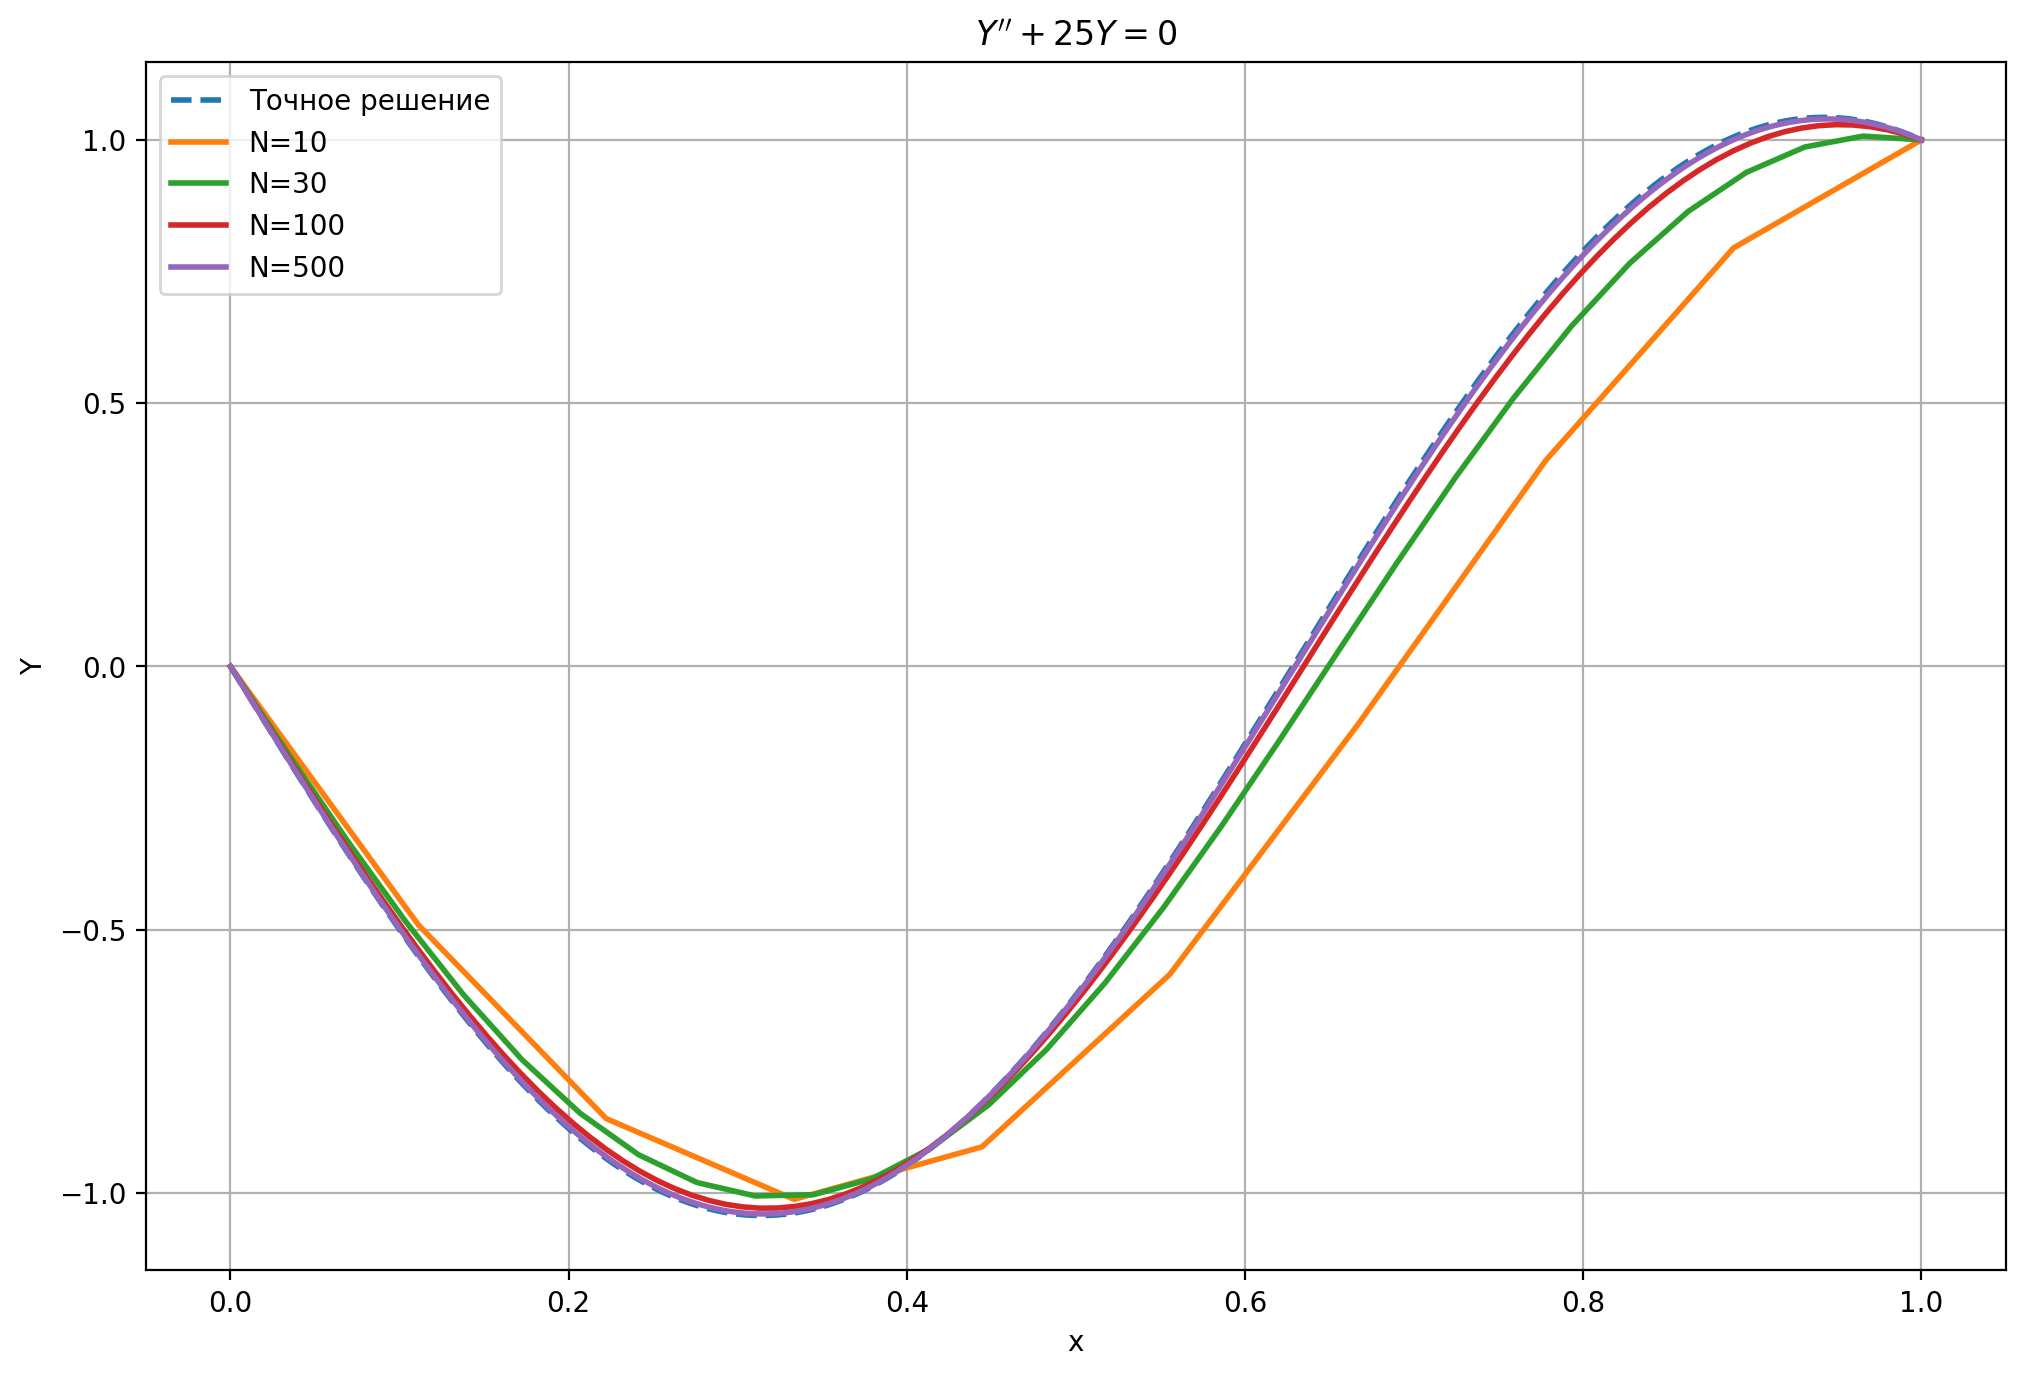

In [4]:
fig, (ax) = plt.subplots(figsize=(12, 8), dpi=200)

x = np.linspace(0, 1, 1_000_000)
Y = np.sin(5 * x) / np.sin(5)
ax.plot(x, Y, '--', label='Точное решение', linewidth=2)

for nodes_number in (10, 30, 100, 500):
    x = np.linspace(0, 1, nodes_number)
    Y = solve_second_order_lde(0, 25, 0, Y_left=0, Y_right=1, x=x)
    ax.plot(x, Y[-1], label=f'N={nodes_number}', linewidth=2)

ax.set_title('$Y\'\' + 25 Y = 0$')
ax.set_xlabel('x')
ax.set_ylabel('Y')
ax.grid(True)
ax.legend()
fig.savefig('1')

3


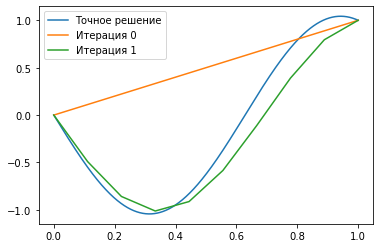

In [5]:
from itertools import islice


fig, ax = plt.subplots()

x = np.linspace(0, 1, 1_000_000)
Y = np.sin(5 * x) / np.sin(5)
ax.plot(x, Y, label='Точное решение')

x = np.linspace(0, 1, 10)
solution = solve_second_order_lde(0, 25, 0, Y_left=0, Y_right=1, x=x)
print(len(solution))
for iteration_number, Y in islice(enumerate(solution), 0, len(solution) - 1):
    ax.plot(x, Y, label=f'Итерация {iteration_number}')

ax.legend()
fig.show()

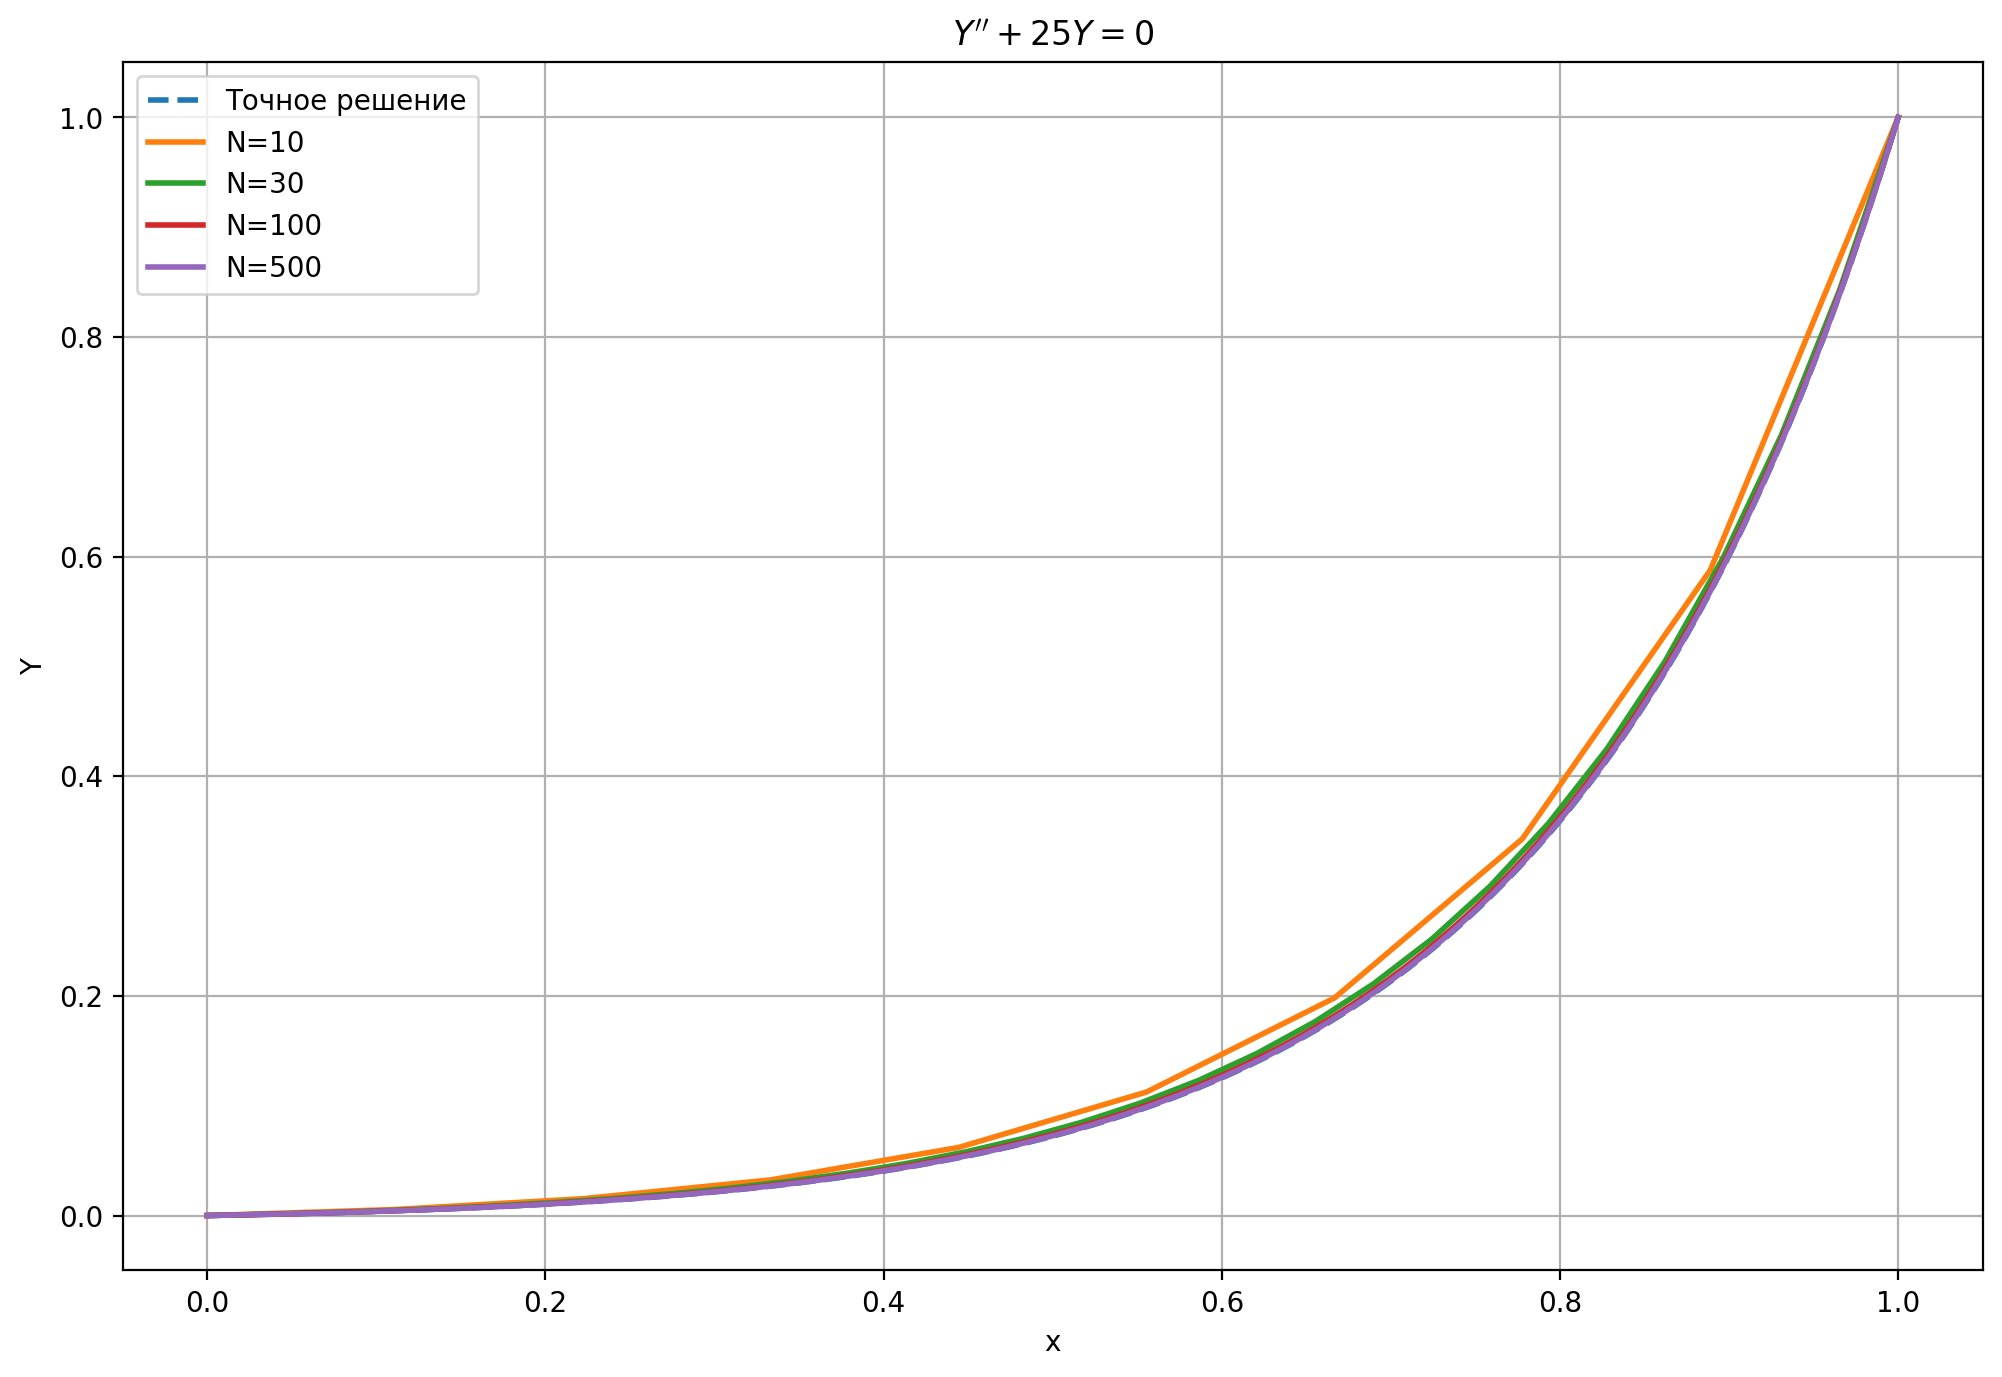

In [6]:
fig, (ax) = plt.subplots(figsize=(12, 8), dpi=200)

x = np.linspace(0, 1, 1_000_000)
Y = np.exp(x - 1) * (np.exp(4 * x) - 1) / (np.exp(4) - 1)
ax.plot(x, Y, '--', label='Точное решение', linewidth=2)

for nodes_number in (10, 30, 100, 500):
    x = np.linspace(0, 1, nodes_number)
    Y = solve_second_order_lde(-6, 5, 0, Y_left=0, Y_right=1, x=x)
    ax.plot(x, Y[-1], label=f'N={nodes_number}', linewidth=2)

ax.set_title('$Y\'\' + 25 Y = 0$')
ax.set_xlabel('x')
ax.set_ylabel('Y')
ax.grid(True)
ax.legend()
fig.savefig('2')

In [7]:
def solve_golovin_equation(
    *, 
    epsilon: float, 
    x: np.ndarray, 
    Y_left: float, 
    Y_right: float, 
    precision: float = 1e-3, 
    max_iterations_count: int = 1000
) -> np.ndarray:
    """
    eplsilon * Y'' + Y * Y' - Y = 0
    """
    h = (x[-1] - x[0]) / len(x)

    Y = np.array([Y_left + (Y_right - Y_left) * x])

    norm = +inf

    while norm > precision and len(Y) <= max_iterations_count:
        Y_prev = Y[-1]

        a = epsilon - h / 2 * Y_prev[2:-1]
        b = -1 * (2 * epsilon + h ** 2) * np.ones((len(x) - 2, ))
        c = epsilon + h / 2 * Y_prev[1:-2]

        d = np.zeros((len(x) - 2, ))
        d[0] = d[0] - (epsilon - h / 2 * Y_prev[1]) * Y_left
        d[-1] = d[-1] - (epsilon + h / 2 * Y_prev[-2]) * Y_right

        solution = solve_tridiagonal_matrix_system(a, b, c, d)
        Y_current = np.array([Y_left, *solution, Y_right])

        norm = np.max(np.abs(Y_current - Y_prev))
        Y = np.append(Y, [Y_current], axis=0)

    return Y


1000


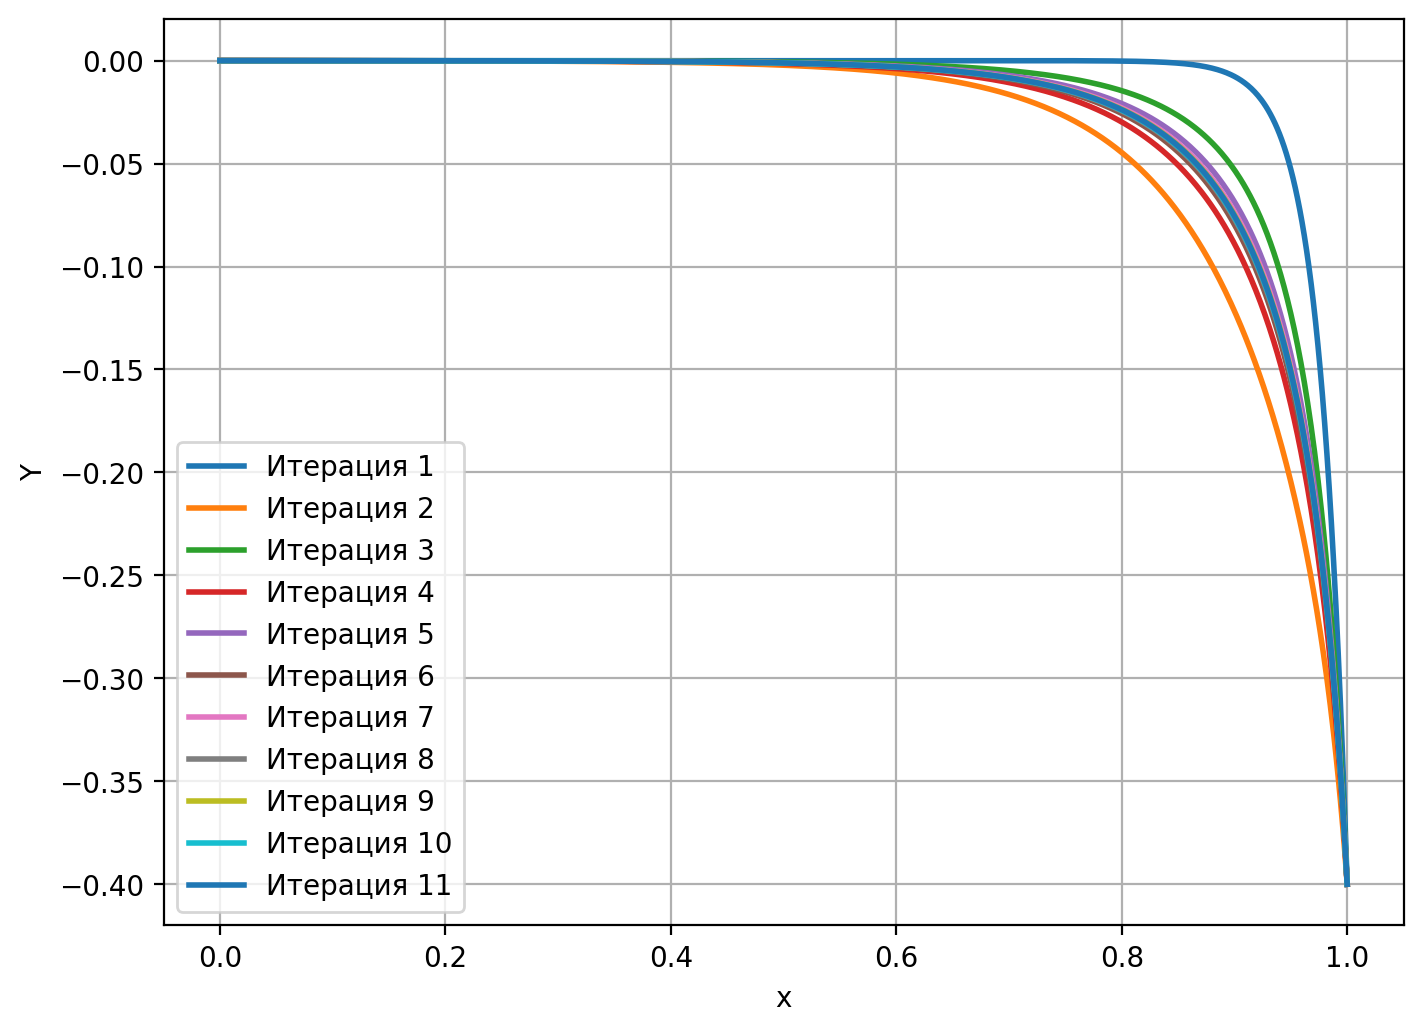

In [26]:
fig, (ax) = plt.subplots(figsize=(8, 6), dpi=200)

x = np.linspace(0, 1, 1000)
solution = solve_golovin_equation(epsilon=1e-2, x=x, Y_left=0, Y_right=-0.4)

for iteration_number, Y in list(enumerate(solution))[1:]:
    ax.plot(x, Y, label=f'Итерация {iteration_number}', linewidth=2)

print(len(solution[-1]))
ax.set_xlabel('x')
ax.set_ylabel('Y')
ax.grid(True)
ax.legend()
fig.show()

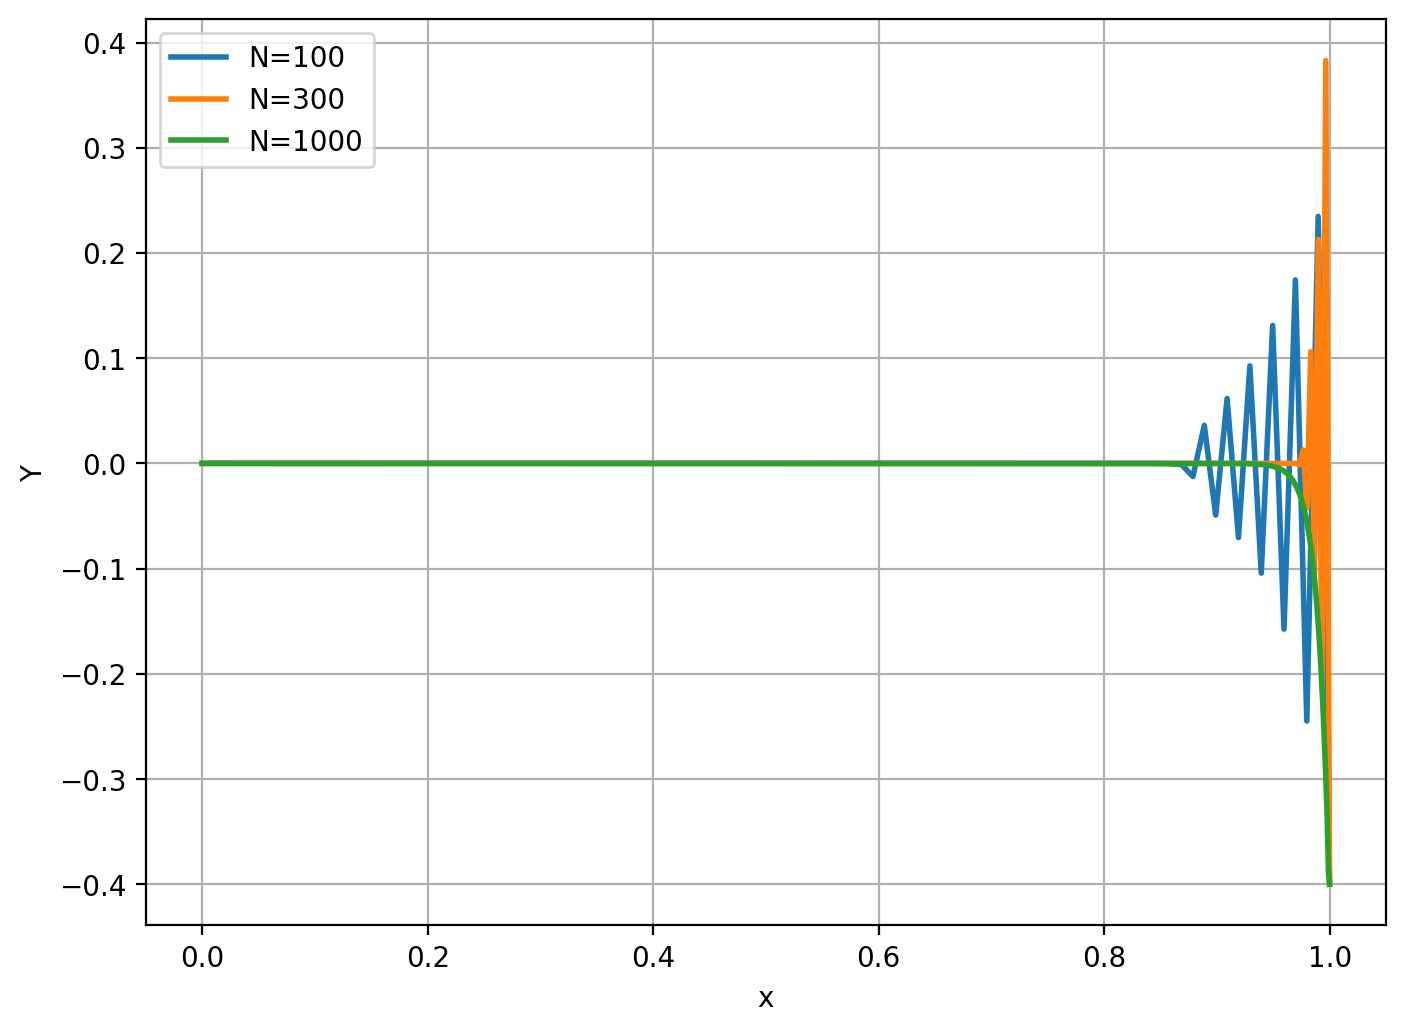

In [30]:
fig, (ax) = plt.subplots(figsize=(8, 6), dpi=200)

for nodes_number in (100, 300, 1000):
    x = np.linspace(0, 1, nodes_number)
    Y = solve_golovin_equation(epsilon=1e-4, x=x, Y_left=0, Y_right=-0.4)
    ax.plot(x, Y[-1], label=f'N={nodes_number}', linewidth=2)

ax.set_xlabel('x')
ax.set_ylabel('Y')
ax.grid(True)
ax.legend()
fig.savefig('1')

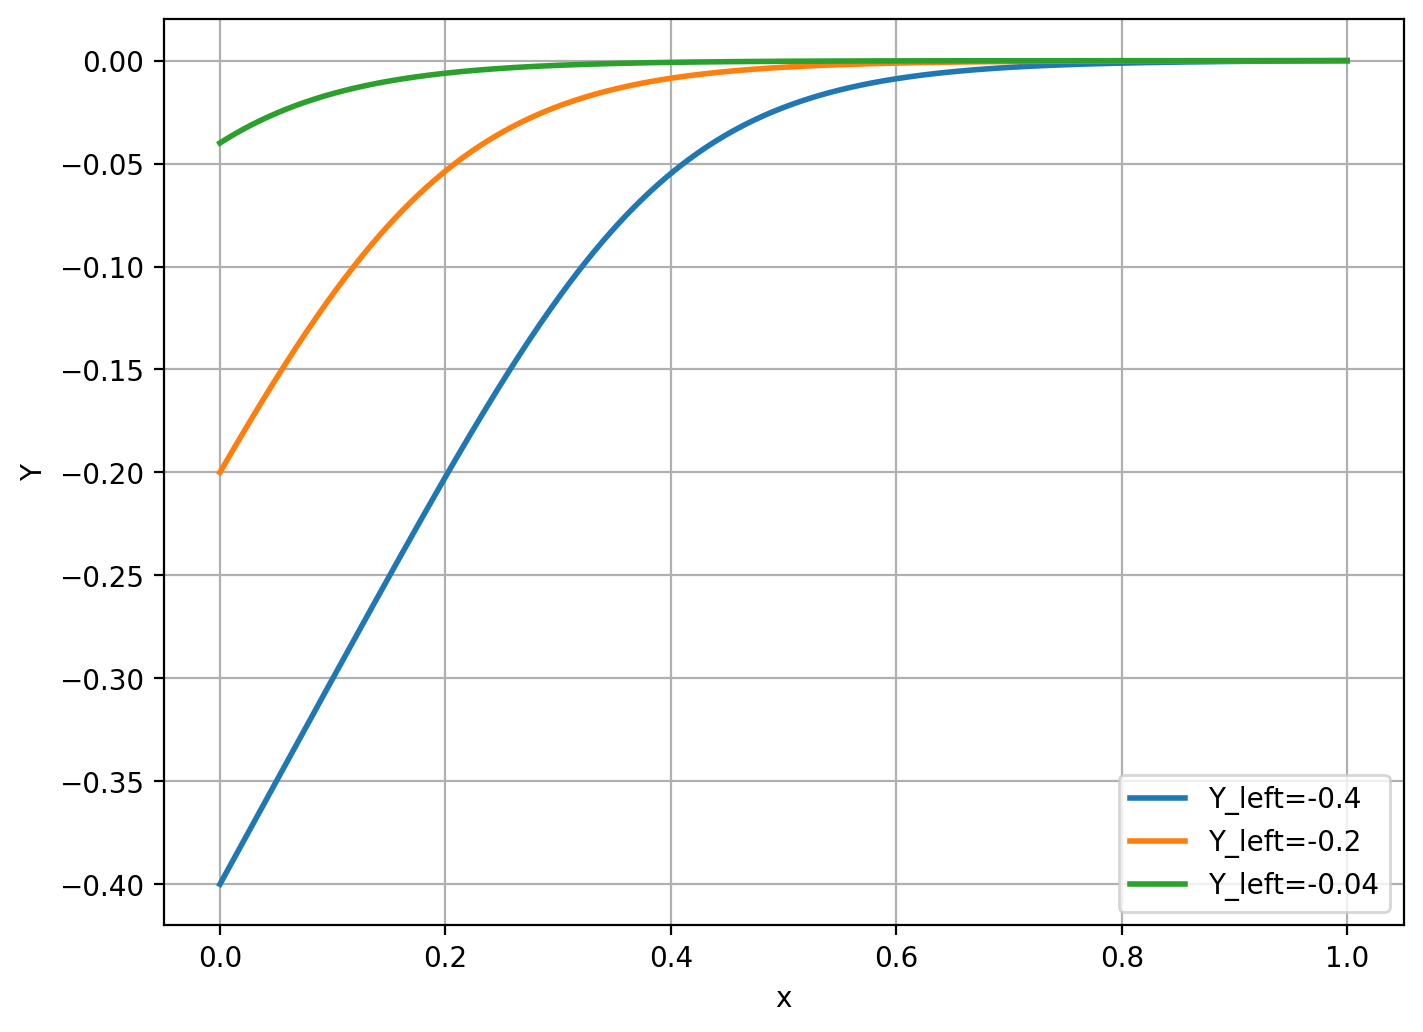

In [10]:
fig, (ax) = plt.subplots(figsize=(8, 6), dpi=200)

x = np.linspace(0, 1, 10000)

for Y_left in (-0.4, -0.2, -0.04):
    Y = solve_golovin_equation(epsilon=1e-2, x=x, Y_left=Y_left, Y_right=0)
    ax.plot(x, Y[-1], label=f'Y_left={Y_left}', linewidth=2)

ax.set_xlabel('x')
ax.set_ylabel('Y')
ax.grid(True)
ax.legend()
fig.show()

1000


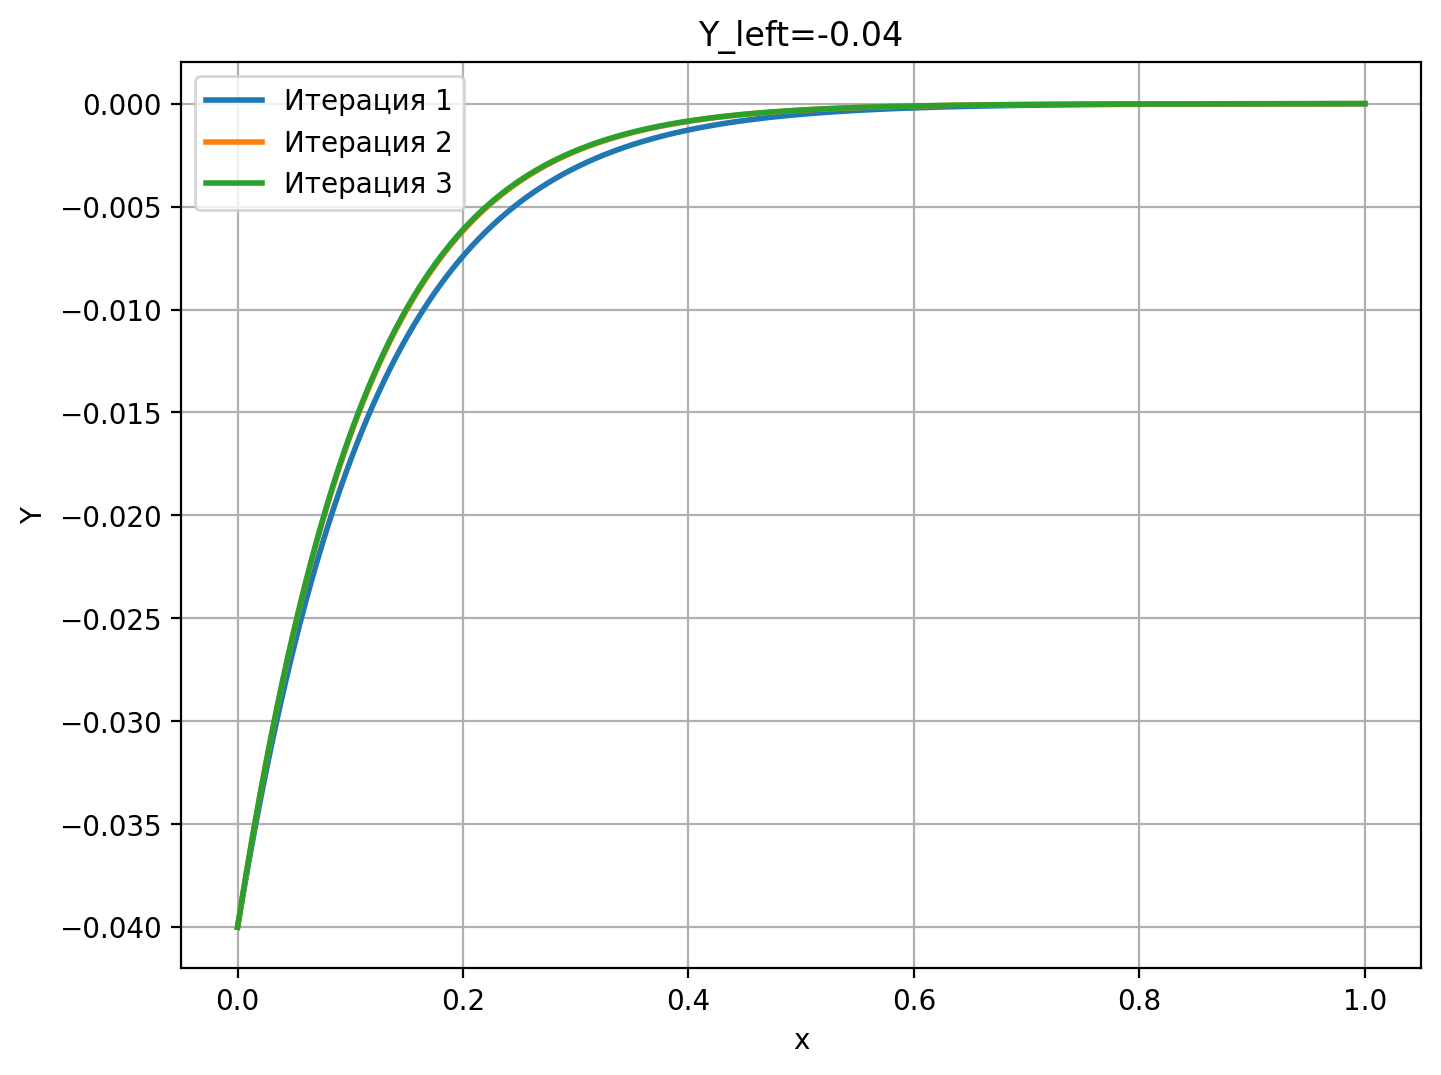

In [11]:
fig, (ax) = plt.subplots(figsize=(8, 6), dpi=200)

Y_left = -0.04
x = np.linspace(0, 1, 1000)
solution = solve_golovin_equation(epsilon=1e-2, x=x, Y_left=Y_left, Y_right=0)

for iteration_number, Y in list(enumerate(solution))[1:]:
    ax.plot(x, Y, label=f'Итерация {iteration_number}', linewidth=2)

print(len(solution[-1]))
ax.set_xlabel('x')
ax.set_ylabel('Y')
ax.set_title(f'Y_left={Y_left}')
ax.grid(True)
ax.legend()
fig.show()